# Kaggle Titanic - TensorFlow basic

* 참고 : https://github.com/wangchen1ren/Titanic/blob/master/01_tensorflow_basic.py
* 위 링크의 소스를 참고하였다.
* 결측치를 사이킷런을 통해 보정해 주었다.
* 카테고리 데이터를 one-hot-encoding 해주도록 했다.
* 구글 Colaboratory에서 파일을 로드할 수 있는 코드를 추가하였다.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load Data

### Google colab

In [2]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [3]:
# import io

# train_df = pd.read_csv(
#     io.StringIO(uploaded['train.csv'].decode('utf-8')), header=0)

# test_df = pd.read_csv(
#     io.StringIO(uploaded['test.csv'].decode('utf-8')), header=0)

### local file load

In [4]:
# read data from file
data = pd.read_csv('data/train.csv')
testdata = pd.read_csv('data/test.csv')

## Preparing Data

In [5]:
# fill nan values with 0
# 결측치에 아래와 같이 0을 채워줘도 되지만 사이킷런의 Imputer를 통해 채워주도록 했다.
# data = data.fillna(0)
# testdata = testdata.fillna(0)

In [6]:
# 성별을 0과 1로 one hot encoding
# 아래와 같이 인코딩 해줄 수도 있지만 판다스의 get_dummies를 사용해서 인코딩했다.
# data['Sex'] = data['Sex'].apply(lambda s: 1 if s == 'male' else 0)
# testdata['Sex'] = testdata['Sex'].apply(lambda s: 1 if s == 'male' else 0)

In [7]:
from sklearn.preprocessing import Imputer

# 결측치를 보완해 준다.
def nan_padding(data, columns):
    for column in columns:
        imputer = Imputer()
        data[column] = imputer.fit_transform(data[column].values.reshape(-1,1))
    return data


nan_columns = ["Age", "SibSp", "Parch", "Fare"]

data = nan_padding(data, nan_columns)
testdata = nan_padding(testdata, nan_columns)

In [8]:
# 기계가 데이터를 이해할 수 있도록 
# 카테고리 데이터를 one-hot-encoding 해준다.
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data


dummy_columns = ["Sex", "Pclass", "Embarked"]
data = dummy_data(data, dummy_columns)
testdata = dummy_data(testdata, dummy_columns)

In [9]:
data.head(3)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1


In [10]:
X_train = data.copy()
X_test = testdata.copy()

In [11]:
# 사용하지 않을 컬럼을 제거해 준다.
def drop_not_concerned(data, columns):
    return data.drop(columns, axis=1)

not_concerned_columns = ["PassengerId", "Name", "Ticket", "Cabin"]
X_train = drop_not_concerned(X_train, not_concerned_columns)
X_train = X_train.drop('Survived', axis=1)
X_test = drop_not_concerned(X_test, not_concerned_columns)

In [12]:
X_train.head(3)

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1.0,0.0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1.0,0.0,71.2833,1,0,1,0,0,1,0,0
2,26.0,0.0,0.0,7.9250,1,0,0,0,1,0,0,1


In [13]:
X_test.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0.0,0.0,7.8292,0,1,0,0,1,0,1,0
1,47.0,1.0,0.0,7.0000,1,0,0,0,1,0,0,1
2,62.0,0.0,0.0,9.6875,0,1,0,1,0,0,1,0
3,27.0,0.0,0.0,8.6625,0,1,0,0,1,0,0,1
4,22.0,1.0,1.0,12.2875,1,0,0,0,1,0,0,1


In [14]:
# 'Survived' is the label of one class,
# add 'Deceased' as the other class
data['Deceased'] = data['Survived'].apply(lambda s: 1 - s)

# select features and labels for training
# dataset_X = data[['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']].as_matrix()
dataset_X = X_train.as_matrix()
dataset_Y = data[['Deceased', 'Survived']].as_matrix()

# split training data and validation set data
X_train, X_val, y_train, y_val = train_test_split(dataset_X, dataset_Y,
                                                  test_size = 0.2,
                                                  random_state = 2018)

# X_test = testdata[['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]

In [15]:
X_train.shape

(712, 12)

In [16]:
X_test.shape

(418, 12)

## Constructing Dataflow Graph

In [26]:
tf.set_random_seed(2018)

# create symbolic variables
# shape에 None을 지정해 주면 넘겨주는 피처 행의 갯수가 되며 피처의 columns수를 지정해 준다.
X = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]])
y = tf.placeholder(tf.float32, shape=[None, 2])

# Variable은 TensorFlow의 상호작용하는 작업 그래프들간에 유지되는 변경 가능한 텐서
# weights and bias are the variables to be trained
weights = tf.Variable(
    tf.random_normal([X_train.shape[1], 2]), 
    name='weights')
bias = tf.Variable(tf.zeros([2]), name='bias')
y_pred = tf.nn.softmax(tf.matmul(X, weights) + bias)

# 크로스 엔트로피 최소화
# Minimise cost using cross entropy
# NOTE: add a epsilon(1e-10) when calculate log(y_pred),
# otherwise the result will be -inf
cross_entropy = - tf.reduce_sum(y * tf.log(y_pred + 1e-10),
                                reduction_indices=1)
cost = tf.reduce_mean(cross_entropy)

# use gradient descent optimizer to minimize cost
# 그라디언트디센트를 사용해 cost를 최소화하는 최적점을 찾는다.
train_op = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

# 정확도를 계산                                                                          
# calculate accuracy
correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(y_pred, 1))
acc_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training and Evaluating the model

In [51]:
x_collect = []
train_loss_collect = []

# use session to run the calculation
with tf.Session() as sess:
    # variables have to be initialized at the first place
    tf.global_variables_initializer().run()

    # training loop
    for epoch in range(200):
        total_loss = 0.
        for i in range(len(X_train)):
            # prepare feed data and run
            feed_dict = {X: [X_train[i]], y: [y_train[i]]}
            _, loss = sess.run([train_op, cost], feed_dict=feed_dict)
            total_loss += loss
            
        x_collect.append(epoch)
        train_loss_collect.append(total_loss)
        
        # display loss per 20 epoch
        if epoch % 20 == 0:
            print('Epoch: %04d, total loss=%.9f' % (epoch + 1, total_loss))

    # Accuracy calculated by TensorFlow
    # 텐서플로우로 정확도 측정
    accuracy = sess.run(acc_op, feed_dict={X: X_val, y: y_val})
    print("Accuracy on validation set: %.9f" % accuracy)

    # Accuracy calculated by NumPy
    # 넘파이로 정확도를 측정
    pred = sess.run(y_pred, feed_dict={X: X_val})
    correct = np.equal(np.argmax(pred, 1), np.argmax(y_val, 1))
    numpy_accuracy = np.mean(correct.astype(np.float32))
    print("Accuracy on validation set (numpy): %.9f" % numpy_accuracy)

    # predict on test data
    # 테스트 데이터 예측
    predictions = np.argmax(sess.run(y_pred, feed_dict={X: X_test}), 1)
    submission = pd.DataFrame({
        "PassengerId": testdata["PassengerId"],
        "Survived": predictions
    })

Epoch: 0001, total loss=4574.452066221
Epoch: 0021, total loss=899.816097019
Epoch: 0041, total loss=926.288102589
Epoch: 0061, total loss=921.625716744
Epoch: 0081, total loss=959.405456362
Epoch: 0101, total loss=991.706185612
Epoch: 0121, total loss=976.904116947
Epoch: 0141, total loss=981.241350566
Epoch: 0161, total loss=976.357180019
Epoch: 0181, total loss=971.613601407
Accuracy on validation set: 0.810055852
Accuracy on validation set (numpy): 0.810055852


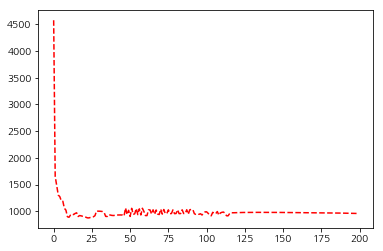

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x_collect, train_loss_collect, "r--")

In [48]:
submission.to_csv("submission/tf-basic-submission-{:.5f}.csv".format(accuracy), index=False)

* 카테고리 데이터를 one-hot-encoding 하지 않았을 때 
    * Accuracy on validation set: 0.726256967
    * Accuracy on validation set (numpy): 0.726256967
    * loss=839.440196298
    
* 카테고리 데이터를 one-hot-encoding 했을 때 캐글 스코어 0.69856
    * Accuracy on validation set: 0.787709475
    * Accuracy on validation set (numpy): 0.787709475
    * loss=939.316331230

In [ ]:
# 캐글 API를 설치하고 Auth 인증해야 사용할 수 있다.
# 제출한 서브미션 목록
!kaggle competitions submissions -c titanic